In [ ]:
#### using biwi kincet head pose dataset
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/12.obj'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/06.obj'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/09.obj'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/14'),Path('/root/.fastai/data/biwi_head_pose/07'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/21.obj')...]

In [ ]:
path

Path('/root/.fastai/data/biwi_head_pose')

In [ ]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00295_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00406_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00169_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00350_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00016_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00477_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00197_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00023_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00216_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00243_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00230_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00011_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00335_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00353_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00472_rgb.jpg'),Path('/r

In [ ]:
### from image path to the pose file

img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/20/frame_00295_pose.txt')

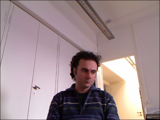

In [ ]:
im = PILImage.create(img_files[0])
im.shape
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

tensor([369.4320, 291.2451])

In [ ]:
biwi = DataBlock(
 blocks=(ImageBlock, PointBlock),
 get_items=get_image_files,
 get_y=get_ctr,
 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
 batch_tfms=[*aug_transforms(size=(240,320)),
 Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = biwi.dataloaders(path)

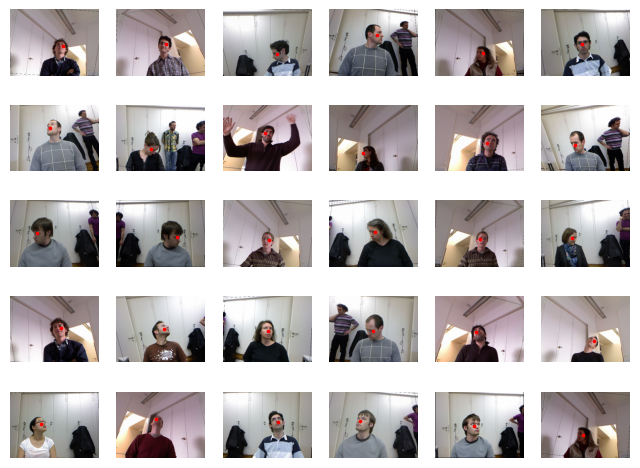

In [ ]:
dls.show_batch(max_n=30,figsize=(8,6))

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.4MB/s]


In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

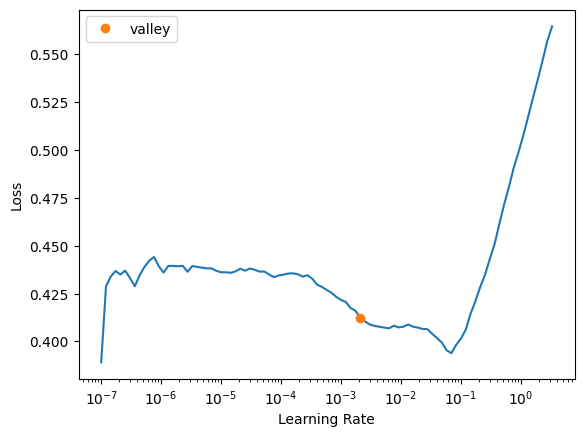

In [ ]:
min_lr = learn.lr_find()

In [ ]:
min_lr

SuggestedLRs(valley=0.0020892962347716093)

In [ ]:
learn.fit_one_cycle(5, min_lr)

epoch,train_loss,valid_loss,time
0,0.179942,0.010414,01:47
1,0.015478,0.005970,01:48
2,0.008384,0.000613,01:47


epoch,train_loss,valid_loss,time
0,0.179942,0.010414,01:47
1,0.015478,0.005970,01:48
2,0.008384,0.000613,01:47
3,0.005551,0.001382,01:47
4,0.004244,0.001244,01:42


In [ ]:
from fastai.metrics import R2Score

learn.metrics = [R2Score()]

In [ ]:
learn.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x7d76d61a5060>]

In [ ]:
learn.fit_one_cycle(5, min_lr)

epoch,train_loss,valid_loss,r2_score,time
0,0.005559,0.004932,0.181715,01:52
1,0.004666,0.002258,0.625317,01:43
2,0.003337,0.001957,0.675226,01:42
3,0.002172,0.000476,0.920954,01:38
4,0.001882,0.000453,0.924773,01:43


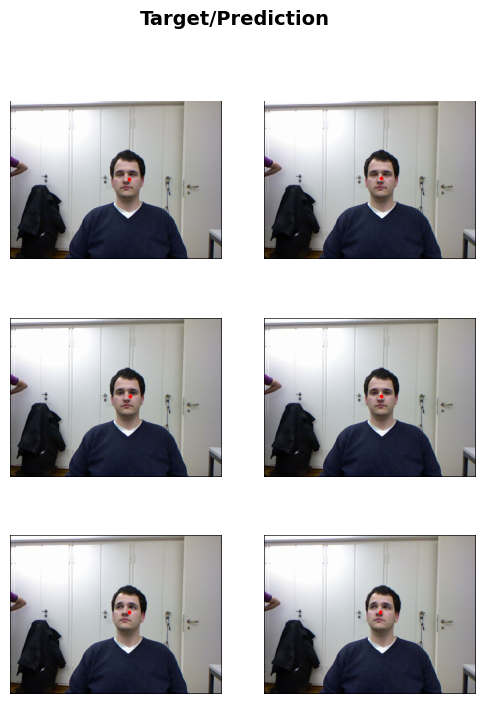

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))